# 🧱 DCGAN - 블록 데이터

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/01_dcgan/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2023-05-24 06:43:22--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-05-24 06:43:22 (39.4 MB/s) - ‘utils.py’ saved [771/771]



이 노트북에서는 레고 블록 데이터셋에서 DCGAN을 훈련합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100 # 훈련이 오래 걸려 에포크 횟수를 300에서 100으로 줄입니다.
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. 데이터 준비 <a name="prepare"></a>

In [4]:
# 코랩일 경우 노트북에서 celeba 데이터셋을 받습니다.
if 'google.colab' in sys.modules:
    # 캐글-->Setttings-->API-->Create New Token에서 
    # kaggle.json 파일을 만들어 코랩에 업로드하세요.
    from google.colab import files
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    # celeba 데이터셋을 다운로드하고 압축을 해제합니다.
    !kaggle datasets download -d joosthazelzet/lego-brick-images
    !unzip -q lego-brick-images.zip
    # output 디렉토리를 만듭니다.
    !mkdir output

Saving kaggle.json to kaggle.json
100% 1.00G/1.00G [00:45<00:00, 30.3MB/s]
100% 1.00G/1.00G [00:45<00:00, 23.4MB/s]


In [5]:
train_data = utils.image_dataset_from_directory(
    "./dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


In [6]:
def preprocess(img):
    """
    이미지 정규화 및 크기 변경
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [7]:
train_sample = sample_batch(train)

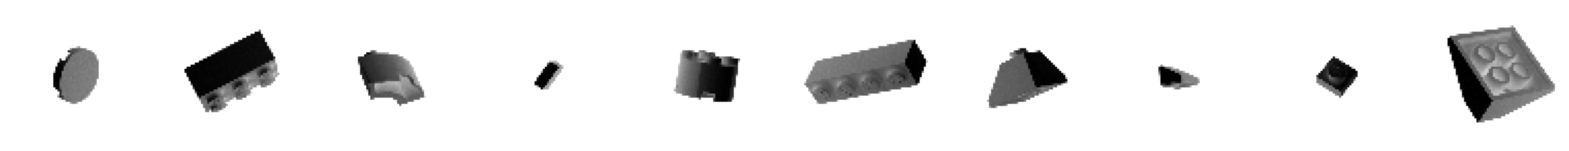

In [8]:
display(train_sample)

## 2. GAN 구축 <a name="build"></a>

In [9]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                             

In [10]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [11]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # 잠재 공간에서 랜덤 포인트 샘플링
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 가짜 이미지로 판별자 훈련하기
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # 메트릭 업데이트
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [12]:
# DCGAN 생성
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [13]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. GAN 훈련 <a name="train"></a>

In [14]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [15]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0: # 출력 횟수를 줄이기 위해 
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )

Epoch 1/100
  6/313 [..............................] - ETA: 51s - d_loss: 0.2359 - d_real_acc: 0.8763 - d_fake_acc: 0.8112 - d_acc: 0.8438 - g_loss: 1.8065 - g_acc: 0.1888

313/313 [==============================] - ETA: 0s - d_loss: 0.2083 - d_real_acc: 0.8537 - d_fake_acc: 0.8658 - d_acc: 0.8598 - g_loss: 4.4704 - g_acc: 0.1341
Saved to ./output/generated_img_000.png


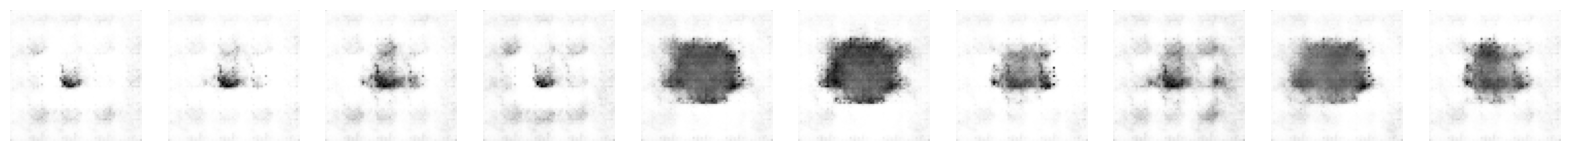

313/313 [==============================] - 92s 242ms/step - d_loss: 0.2083 - d_real_acc: 0.8537 - d_fake_acc: 0.8658 - d_acc: 0.8598 - g_loss: 4.4704 - g_acc: 0.1341
Epoch 2/100
313/313 [==============================] - 76s 238ms/step - d_loss: 0.0299 - d_real_acc: 0.9007 - d_fake_acc: 0.9143 - d_acc: 0.9075 - g_loss: 4.9732 - g_acc: 0.0857
Epoch 3/100
313/313 [==============================] - 76s 239ms/step - d_loss: 0.0454 - d_real_acc: 0.8970 - d_fake_acc: 0.9014 - d_acc: 0.8992 - g_loss: 5.8870 - g_acc: 0.0986
Epoch 4/100
313/313 [==============================] - 78s 244ms/step - d_loss: -0.0108 - d_real_acc: 0.9094 - d_fake_acc: 0.9124 - d_acc: 0.9109 - g_loss: 5.3530 - g_acc: 0.0876
Epoch 5/100
313/313 [==============================] - 76s 239ms/step - d_loss: 0.1437 - d_real_acc: 0.8757 - d_fake_acc: 0.8757 - d_acc: 0.8757 - g_loss: 4.7777 - g_acc: 0.1243
Epoch 6/100
313/313 [==============================] - 77s 243ms/step - d_loss: 0.1027 - d_real_acc: 0.8869 - d_fake_acc:

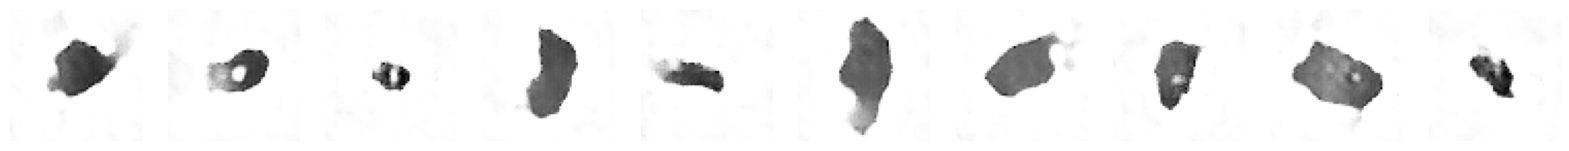

313/313 [==============================] - 77s 240ms/step - d_loss: 0.0375 - d_real_acc: 0.9057 - d_fake_acc: 0.9059 - d_acc: 0.9058 - g_loss: 4.9551 - g_acc: 0.0941
Epoch 12/100
313/313 [==============================] - 75s 234ms/step - d_loss: 0.0538 - d_real_acc: 0.9010 - d_fake_acc: 0.9001 - d_acc: 0.9005 - g_loss: 4.8114 - g_acc: 0.0999
Epoch 13/100
313/313 [==============================] - 76s 237ms/step - d_loss: 0.0637 - d_real_acc: 0.9043 - d_fake_acc: 0.9064 - d_acc: 0.9053 - g_loss: 4.9717 - g_acc: 0.0936
Epoch 14/100
313/313 [==============================] - 76s 237ms/step - d_loss: 0.0114 - d_real_acc: 0.9227 - d_fake_acc: 0.9204 - d_acc: 0.9216 - g_loss: 5.4258 - g_acc: 0.0796
Epoch 15/100
313/313 [==============================] - 75s 233ms/step - d_loss: 0.0204 - d_real_acc: 0.9128 - d_fake_acc: 0.9161 - d_acc: 0.9144 - g_loss: 4.8845 - g_acc: 0.0839
Epoch 16/100
313/313 [==============================] - 75s 234ms/step - d_loss: -0.0207 - d_real_acc: 0.9282 - d_fake

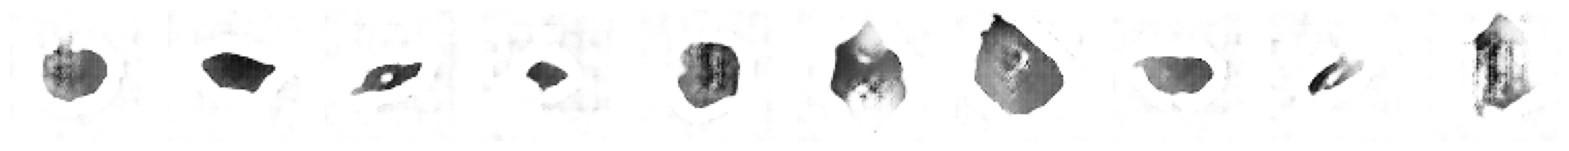

313/313 [==============================] - 78s 242ms/step - d_loss: -0.0766 - d_real_acc: 0.9323 - d_fake_acc: 0.9333 - d_acc: 0.9328 - g_loss: 6.3454 - g_acc: 0.0667
Epoch 22/100
313/313 [==============================] - 76s 234ms/step - d_loss: -0.0466 - d_real_acc: 0.9297 - d_fake_acc: 0.9297 - d_acc: 0.9297 - g_loss: 6.3417 - g_acc: 0.0703
Epoch 23/100
313/313 [==============================] - 76s 234ms/step - d_loss: -0.0987 - d_real_acc: 0.9369 - d_fake_acc: 0.9378 - d_acc: 0.9374 - g_loss: 6.4310 - g_acc: 0.0622
Epoch 24/100
313/313 [==============================] - 76s 238ms/step - d_loss: -0.0508 - d_real_acc: 0.9315 - d_fake_acc: 0.9317 - d_acc: 0.9316 - g_loss: 6.6904 - g_acc: 0.0683
Epoch 25/100
313/313 [==============================] - 77s 240ms/step - d_loss: -0.1515 - d_real_acc: 0.9481 - d_fake_acc: 0.9499 - d_acc: 0.9490 - g_loss: 7.4483 - g_acc: 0.0501
Epoch 26/100
313/313 [==============================] - 75s 234ms/step - d_loss: 0.0125 - d_real_acc: 0.9221 - d_

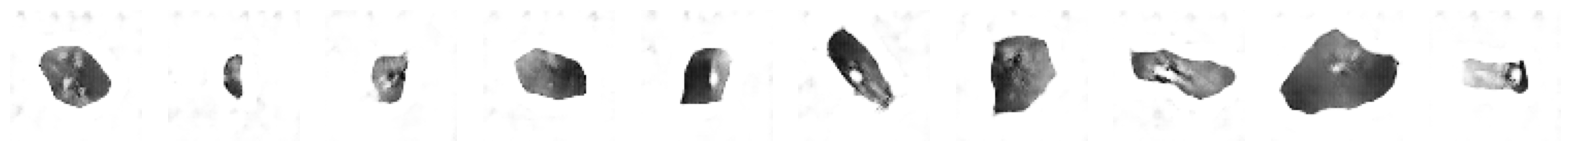

313/313 [==============================] - 74s 232ms/step - d_loss: -0.1463 - d_real_acc: 0.9403 - d_fake_acc: 0.9412 - d_acc: 0.9407 - g_loss: 7.7424 - g_acc: 0.0588
Epoch 32/100
313/313 [==============================] - 75s 232ms/step - d_loss: -0.1191 - d_real_acc: 0.9318 - d_fake_acc: 0.9345 - d_acc: 0.9331 - g_loss: 7.7798 - g_acc: 0.0655
Epoch 33/100
313/313 [==============================] - 75s 233ms/step - d_loss: 0.0410 - d_real_acc: 0.9165 - d_fake_acc: 0.9255 - d_acc: 0.9210 - g_loss: 7.4741 - g_acc: 0.0745
Epoch 34/100
313/313 [==============================] - 75s 233ms/step - d_loss: -0.3052 - d_real_acc: 0.9602 - d_fake_acc: 0.9609 - d_acc: 0.9605 - g_loss: 8.8316 - g_acc: 0.0391
Epoch 35/100
313/313 [==============================] - 76s 237ms/step - d_loss: -0.1451 - d_real_acc: 0.9359 - d_fake_acc: 0.9418 - d_acc: 0.9389 - g_loss: 8.4866 - g_acc: 0.0582
Epoch 36/100
313/313 [==============================] - 75s 234ms/step - d_loss: -0.2671 - d_real_acc: 0.9552 - d_

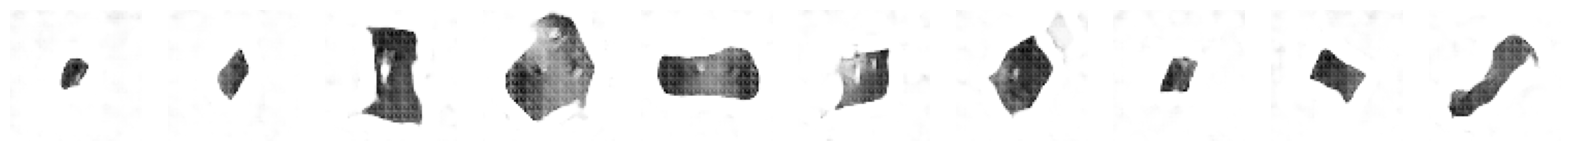

313/313 [==============================] - 76s 237ms/step - d_loss: -0.7557 - d_real_acc: 0.9998 - d_fake_acc: 0.9997 - d_acc: 0.9998 - g_loss: 15.2620 - g_acc: 2.7500e-04
Epoch 42/100
313/313 [==============================] - 75s 237ms/step - d_loss: 0.9742 - d_real_acc: 0.7995 - d_fake_acc: 0.9444 - d_acc: 0.8719 - g_loss: 12.0311 - g_acc: 0.0556
Epoch 43/100
313/313 [==============================] - 74s 233ms/step - d_loss: -0.6717 - d_real_acc: 0.9951 - d_fake_acc: 0.9949 - d_acc: 0.9950 - g_loss: 13.8334 - g_acc: 0.0051
Epoch 44/100
313/313 [==============================] - 74s 231ms/step - d_loss: -0.7624 - d_real_acc: 1.0000 - d_fake_acc: 0.9998 - d_acc: 0.9999 - g_loss: 15.3111 - g_acc: 1.7500e-04
Epoch 45/100
313/313 [==============================] - 74s 233ms/step - d_loss: -0.7663 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4246 - g_acc: 0.0000e+00
Epoch 46/100
313/313 [==============================] - 75s 236ms/step - d_loss: -0.7662 - d_real

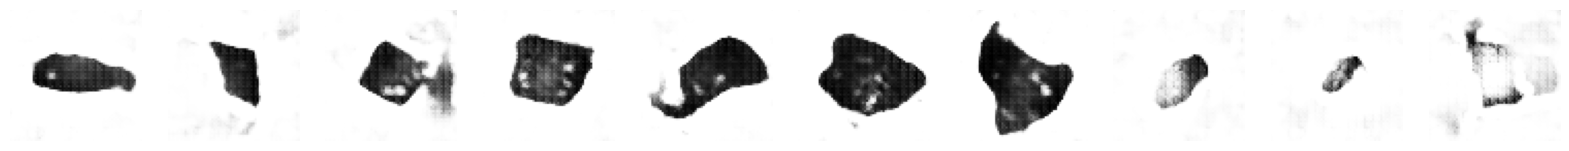

313/313 [==============================] - 75s 236ms/step - d_loss: -0.7664 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4234 - g_acc: 0.0000e+00
Epoch 52/100
313/313 [==============================] - 74s 231ms/step - d_loss: -0.7676 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4240 - g_acc: 0.0000e+00
Epoch 53/100
313/313 [==============================] - 75s 234ms/step - d_loss: -0.7665 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4239 - g_acc: 0.0000e+00
Epoch 54/100
313/313 [==============================] - 74s 232ms/step - d_loss: -0.4406 - d_real_acc: 0.9635 - d_fake_acc: 0.9968 - d_acc: 0.9801 - g_loss: 15.3653 - g_acc: 0.0032
Epoch 55/100
313/313 [==============================] - 74s 231ms/step - d_loss: 7.7141 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 56/100
313/313 [==============================] - 74s 231ms/step - d_loss: 7.7133 -

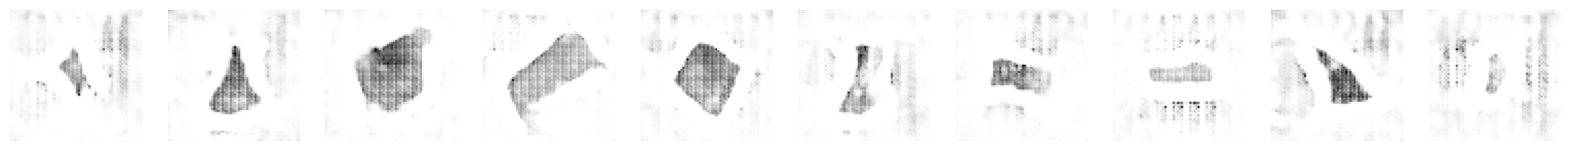

313/313 [==============================] - 75s 236ms/step - d_loss: 7.7121 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 62/100
313/313 [==============================] - 73s 229ms/step - d_loss: 7.7113 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 63/100
313/313 [==============================] - 74s 231ms/step - d_loss: 7.7114 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 64/100
313/313 [==============================] - 75s 234ms/step - d_loss: 7.7147 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 65/100
313/313 [==============================] - 75s 234ms/step - d_loss: 7.7143 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 66/100
313/313 [==============================] - 74s 231ms/step - 

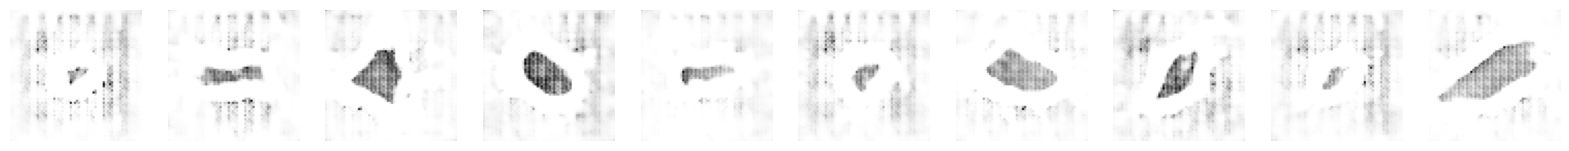

313/313 [==============================] - 74s 232ms/step - d_loss: 7.7117 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 72/100
313/313 [==============================] - 75s 234ms/step - d_loss: 7.7132 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 73/100
313/313 [==============================] - 75s 234ms/step - d_loss: 7.7136 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 74/100
313/313 [==============================] - 74s 232ms/step - d_loss: 7.7129 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 75/100
313/313 [==============================] - 75s 236ms/step - d_loss: 7.7115 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 76/100
313/313 [==============================] - 74s 233ms/step - 

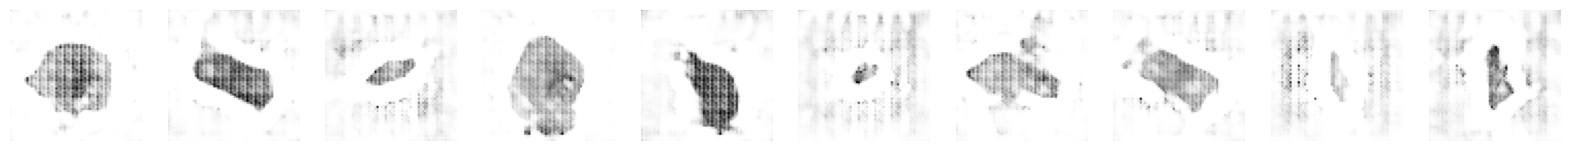

313/313 [==============================] - 75s 234ms/step - d_loss: 7.7101 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 82/100
313/313 [==============================] - 76s 237ms/step - d_loss: 7.7110 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 83/100
313/313 [==============================] - 77s 241ms/step - d_loss: 7.7127 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 84/100
313/313 [==============================] - 77s 238ms/step - d_loss: 7.7141 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 85/100
313/313 [==============================] - 76s 239ms/step - d_loss: 7.7123 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 86/100
313/313 [==============================] - 77s 240ms/step - 

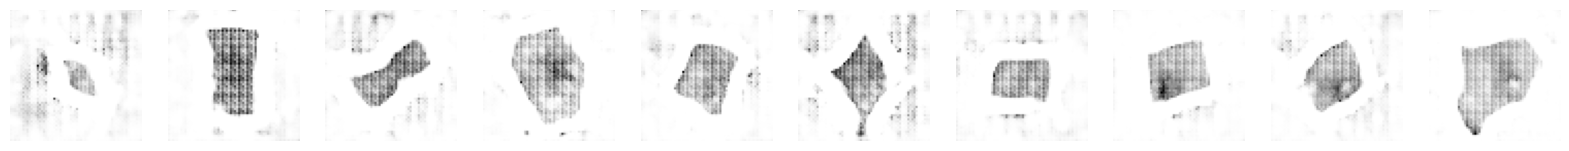

313/313 [==============================] - 76s 239ms/step - d_loss: 7.7092 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 92/100
313/313 [==============================] - 76s 238ms/step - d_loss: 7.7098 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 93/100
313/313 [==============================] - 76s 237ms/step - d_loss: 7.7167 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 94/100
313/313 [==============================] - 77s 242ms/step - d_loss: 7.7144 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 95/100
313/313 [==============================] - 76s 238ms/step - d_loss: 7.7119 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 96/100
313/313 [==============================] - 76s 238ms/step - 

In [16]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [17]:
# 최종 모델 저장
generator.save("./models/generator")
discriminator.save("./models/discriminator")

## 3. 새로운 이미지 생성 <a name="decode"></a>

In [18]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [19]:
# 샘플링된 포인트 디코딩
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 0s 414ms/step


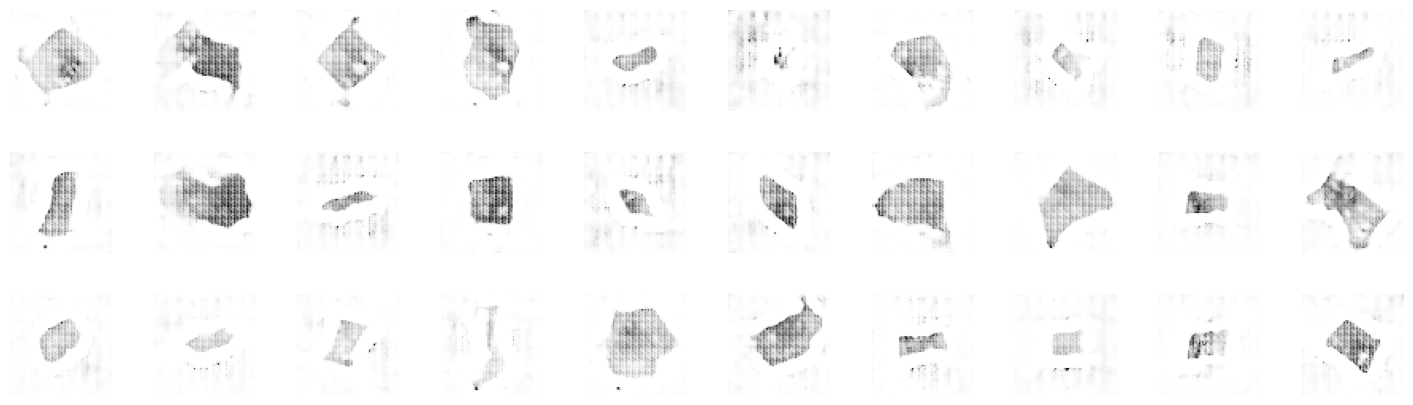

In [20]:
# 디코딩된 이미지 그리기
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 얼굴 그리드 출력
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [21]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [22]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 277ms/step


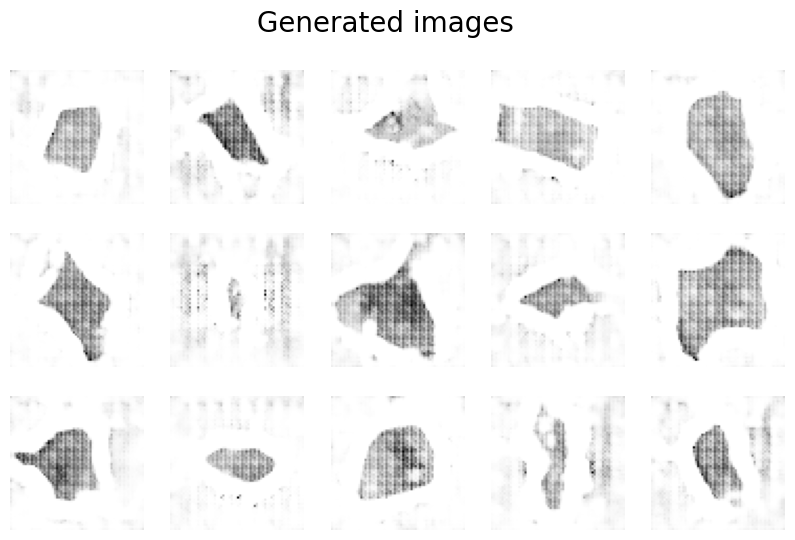

In [23]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

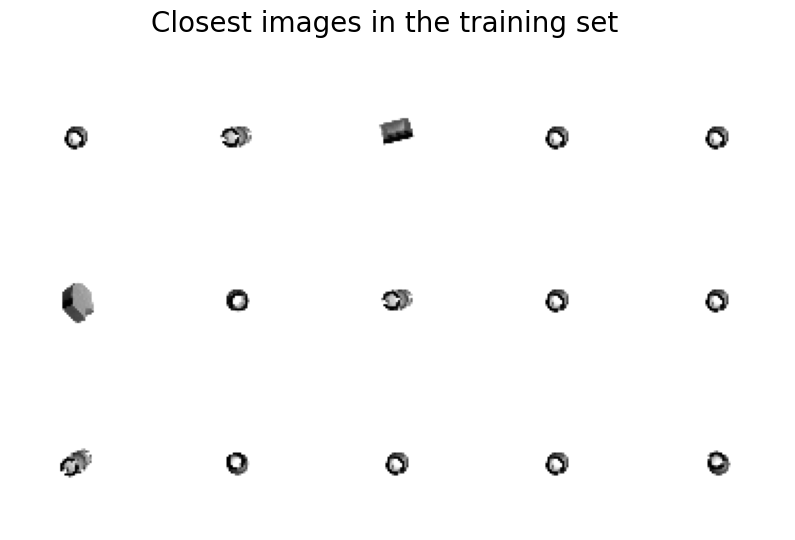

In [24]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()